In [1]:
#| tabs: [parameters]

FDR <- 0.1


In [2]:
setwd("/project/yangili1/cdai/splice-pub/analysis")


In [104]:
#| label: setup
#| include: false

library(tidyverse)
library(data.table)
library(glue)

library(cowplot)


library(GenomicRanges)
library(bedtoolsr)


In [289]:
multiqq <- function(pvalues, flipY = FALSE) {
  library(foreach)
  if (is.null(names(pvalues))) {
    names(pvalues) <- seq_along(pvalues)
  }
  punif <- -log10(runif(max(sapply(pvalues, length))))
  df <- do.call(rbind, foreach(i = seq_len(length(pvalues))) %do% {
    df <- as.data.frame(
      qqplot(
        x = punif[1:length(pvalues[[i]])],
        y = -log10(pvalues[[i]]),
        plot.it = FALSE
      )
    )
    df$group <- names(pvalues)[i]
    df
  })

  if (flipY) {
    df$y <- -df$y
  }

  df$group <- factor(df$group, names(pvalues))
  ggplot(df, aes(x, y, col = group)) +
    geom_point() +
    geom_abline(
      intercept = 0,
      slope = 1
    ) +
    xlab("Expected -log10(p)") +
    ylab("Observed -log10(p)")
}


In [5]:
addLabels <- function(dt) {
  pid_split <- str_split(dt$phenotype_id, ":")
  dt$itype <- map_chr(pid_split, ~ .x[5])
  dt$clu <- map_chr(pid_split, ~ .x[4])
  dt$clu <- str_extract(dt$clu, "clu_[0-9]+")

  dt <- dt[, ctype := paste(sort(unique(itype)), collapse = ","), by = clu][]
  return(dt)
}


In [195]:
tissue <- "Kidney-Cortex"


In [196]:
tissue


[1] "Kidney-Cortex"

In [197]:
readGTExSQTL <- function(tissue) {
  base1.gtex <- "../code/results/qtl/noisy/GTEx/"
  base2.gtex <- "/cis_100000/perm"
  suffix <- "addQval.txt.gz"
  folder <- glue("{base1.gtex}/{tissue}/separateNoise{base2.gtex}")
  files <- glue("{folder}/chr{1:22}.{suffix}")
  dt <- map_dfr(files, fread)
}


In [198]:
permDF <- readGTExSQTL(tissue) %>%
  addLabels()


In [199]:
permDF[1:5]
permDF %>% dim()


phenotype_id,phenotype_chr,phenotype_start,phenotype_end,phenotype_strand,num_variants,best_nom_dist,best_genotype_id,best_genotype_chr,best_genotype_start,⋯,beta_ml2,pval_nom,pval_r2,slope,pval_emp,pval_adj,q,itype,clu,ctype
<chr>,<chr>,<int>,<int>,<chr>,<int>,<int>,<chr>,<chr>,<int>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>
chr1:168165:168609:clu_1788_-:IN,chr1,168166,168609,-,15,33126,chr1_135040_T_C_b38,chr1,135040,⋯,7.13806,0.119357,0.0338209,0.359104,0.623377,0.633855,0.99914,IN,clu_1788,IN
chr1:259025:261549:clu_1789_-:IN,chr1,259026,261549,-,5,-2173,chr1_263722_C_G_b38,chr1,263722,⋯,5.42814,0.264182,0.0175277,-0.202326,0.787213,0.793556,0.99914,IN,clu_1789,IN
chr1:259025:267302:clu_1789_-:IN,chr1,259026,267302,-,5,77361,chr1_181665_A_ATC_b38,chr1,181665,⋯,4.70813,0.152596,0.0286044,0.620455,0.542458,0.554457,0.99914,IN,clu_1789,IN
chr1:261634:267302:clu_1789_-:IN,chr1,261635,267302,-,5,-18084,chr1_285386_T_G_b38,chr1,285386,⋯,4.81805,0.103228,0.0369569,0.487364,0.452547,0.453207,0.99439,IN,clu_1789,IN
chr1:497299:498046:clu_1791_-:IN,chr1,497300,498046,-,2,-93414,chr1_591460_T_C_b38,chr1,591460,⋯,1.91401,0.104412,0.0367092,0.482783,0.210789,0.209782,0.91628,IN,clu_1791,IN


[1] 88437    24

In [200]:
readGTExNOM <- function(tissue) {
  base1.gtex <- "../code/results/eqtl/GTEx"
  paths <- glue("{base1.gtex}/{tissue}/nom/chr{1:22}.txt.gz")
  df <- map_dfr(paths, fread)
  names(df) <- c(
    "pid", "pchr", "pstart", "pend", "pstrand", "nVar", "dist",
    "vid", "vchr", "vstart", "vend", "pval", "r2", "slope", "topflag"
  )
  return(df)
}


In [201]:
nomDF <- readGTExNOM(tissue)


In [202]:
nomDF[1:5]
nomDF %>% dim()


pid,pchr,pstart,pend,pstrand,nVar,dist,vid,vchr,vstart,vend,pval,r2,slope,topflag
<chr>,<chr>,<int>,<int>,<chr>,<int>,<int>,<chr>,<chr>,<int>,<int>,<dbl>,<dbl>,<dbl>,<int>
ENSG00000188157.15,chr1,1020120,1056118,+,239,-885080,chr1_135040_T_C_b38,chr1,135040,135040,0.390182,0.01041840,-0.1442450,0
ENSG00000188976.11,chr1,944203,959309,-,235,809163,chr1_135040_T_C_b38,chr1,135040,135040,0.393674,0.01026660,-0.0950633,0
ENSG00000187583.11,chr1,966482,975865,+,235,-831442,chr1_135040_T_C_b38,chr1,135040,135040,0.404966,0.00978880,-0.1108080,0
ENSG00000131591.17,chr1,1081818,1116361,-,244,946778,chr1_135040_T_C_b38,chr1,135040,135040,0.549487,0.00506836,0.0809281,0
ENSG00000187608.10,chr1,1001138,1014540,+,238,-866098,chr1_135040_T_C_b38,chr1,135040,135040,0.636129,0.00316992,-0.0743253,0


[1] 1565576      15

# first determine p-sQTLs and u-sQTLs, select only 1 per cluster


In [203]:
sqtl <- permDF[q < FDR & itype %in% c("PR", "UP") & ctype %in% c("PR", "PR,UP")]


In [204]:
# select the best intron per cluster based on the largest effect size
sqtl <- sqtl[, rk := frank(-abs(slope), ties.method = "first"), by = .(clu, itype)]


In [205]:
sqtl[1:5]
sqtl %>% dim()


phenotype_id,phenotype_chr,phenotype_start,phenotype_end,phenotype_strand,num_variants,best_nom_dist,best_genotype_id,best_genotype_chr,best_genotype_start,⋯,pval_nom,pval_r2,slope,pval_emp,pval_adj,q,itype,clu,ctype,rk
<chr>,<chr>,<int>,<int>,<chr>,<int>,<int>,<chr>,<chr>,<int>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<int>
chr1:1642508:1645125:clu_1833_-:PR,chr1,1642509,1645125,-,434,15353,chr1_1627156_G_A_b38,chr1,1627156,⋯,5.91221e-06,0.252451,0.951358,0.001998000,1.16070e-03,7.3056e-02,PR,clu_1833,"PR,UP",1
chr1:6637504:6638294:clu_1911_-:PR,chr1,6637505,6638294,-,421,-7590,chr1_6645884_C_T_b38,chr1,6645884,⋯,8.02547e-06,0.246229,-1.672810,0.000999001,1.18817e-03,7.4239e-02,PR,clu_1911,"PR,UP",1
chr1:7961735:7962762:clu_109_+:PR,chr1,7961736,7962762,+,412,0,chr1_7961913_G_T_b38,chr1,7961913,⋯,6.83059e-12,0.486989,1.035680,0.000999001,2.75881e-08,5.6227e-06,PR,clu_109,PR,2
chr1:7961793:7962762:clu_109_+:PR,chr1,7961794,7962762,+,412,0,chr1_7961913_G_T_b38,chr1,7961913,⋯,1.07484e-12,0.512693,-1.085290,0.000999001,4.40780e-09,1.0198e-06,PR,clu_109,PR,1
chr1:16021513:16021619:clu_215_+:UP,chr1,16021514,16021619,+,774,-19893,chr1_16001621_C_T_b38,chr1,16001621,⋯,2.43948e-07,0.314707,-0.895701,0.001998000,1.62851e-04,1.4371e-02,UP,clu_215,"PR,UP",1


[1] 1353   25

In [206]:
sqtl <- rbind(
  sqtl[ctype == "PR"][rk == 1][order(clu)], # best intron for PR cluster
  sqtl[ctype == "PR,UP"][itype == "UP" & rk == 1][order(clu)] # best intron for PR,UP cluster
) %>%
  .[naturalsort::naturalorder(phenotype_id)]


In [207]:
dim(sqtl)
sqtl[1:5]


[1] 692  25

phenotype_id,phenotype_chr,phenotype_start,phenotype_end,phenotype_strand,num_variants,best_nom_dist,best_genotype_id,best_genotype_chr,best_genotype_start,⋯,pval_nom,pval_r2,slope,pval_emp,pval_adj,q,itype,clu,ctype,rk
<chr>,<chr>,<int>,<int>,<chr>,<int>,<int>,<chr>,<chr>,<int>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<int>
chr1:7961793:7962762:clu_109_+:PR,chr1,7961794,7962762,+,412,0,chr1_7961913_G_T_b38,chr1,7961913,⋯,1.07484e-12,0.512693,-1.085290,0.000999001,4.40780e-09,1.0198e-06,PR,clu_109,PR,1
chr1:16021513:16021619:clu_215_+:UP,chr1,16021514,16021619,+,774,-19893,chr1_16001621_C_T_b38,chr1,16001621,⋯,2.43948e-07,0.314707,-0.895701,0.001998000,1.62851e-04,1.4371e-02,UP,clu_215,"PR,UP",1
chr1:18875503:18877207:clu_1991_-:PR,chr1,18875504,18877207,-,768,0,chr1_18876402_G_A_b38,chr1,18876402,⋯,9.57797e-16,0.599323,1.103610,0.000999001,3.90564e-12,1.5920e-09,PR,clu_1991,PR,1
chr1:19326623:19327226:clu_244_+:PR,chr1,19326624,19327226,+,611,23922,chr1_19351148_G_A_b38,chr1,19351148,⋯,7.92200e-06,0.246494,-0.723390,0.001998000,1.53902e-03,9.2775e-02,PR,clu_244,PR,1
chr1:22052868:22078428:clu_265_+:PR,chr1,22052869,22078428,+,849,0,chr1_22056246_A_G_b38,chr1,22056246,⋯,1.25723e-13,0.540947,1.279770,0.000999001,1.23492e-08,2.6427e-06,PR,clu_265,PR,1


In [208]:
sqtl.v <- sqtl[, best_genotype_id] %>% unique()


In [209]:
length(sqtl.v)
sqtl.v[1:5]


[1] 688

[1] "chr1_7961913_G_T_b38"  "chr1_16001621_C_T_b38" "chr1_18876402_G_A_b38"
[4] "chr1_19351148_G_A_b38" "chr1_22056246_A_G_b38"

# select only snps that are top sQTLs from nominal file


In [210]:
nomDF <- nomDF[vid %in% sqtl.v]


In [211]:
nomDF[1:5, ]
dim(nomDF)


pid,pchr,pstart,pend,pstrand,nVar,dist,vid,vchr,vstart,vend,pval,r2,slope,topflag
<chr>,<chr>,<int>,<int>,<chr>,<int>,<int>,<chr>,<chr>,<int>,<int>,<dbl>,<dbl>,<dbl>,<int>
ENSG00000142599.19,chr1,8352397,8848921,-,55,390484,chr1_7961913_G_T_b38,chr1,7961913,7961913,0.460400,0.00769938,0.0755688,0
ENSG00000162426.14,chr1,8317826,8344167,+,38,-355913,chr1_7961913_G_T_b38,chr1,7961913,7961913,0.332440,0.01323560,-0.1038200,0
ENSG00000171735.19,chr1,6785454,7769706,+,135,192207,chr1_7961913_G_T_b38,chr1,7961913,7961913,0.187922,0.02429250,-0.0979608,0
ENSG00000074800.16,chr1,8861000,8879190,-,45,899087,chr1_7961913_G_T_b38,chr1,7961913,7961913,0.264175,0.01752830,0.0972782,0
ENSG00000049245.13,chr1,7771296,7781432,+,35,180481,chr1_7961913_G_T_b38,chr1,7961913,7961913,0.470787,0.00735034,-0.0592743,0


[1] 18523    15

# join the top SQTLs and eQTL nominal


In [212]:
mergeDF <- inner_join(sqtl[, .(phenotype_id, phenotype_chr, phenotype_start, phenotype_end, phenotype_strand, best_genotype_id, best_nom_dist, pval_nom, slope, itype, ctype)],
  nomDF[, .(pid, pchr, pstart, pend, pstrand, vid, dist, pval, slope, topflag)],
  by = c("best_genotype_id" = "vid"),
  suffix = c("_sqtl", "_eqtl"),
  relationship = "many-to-many"
)


In [213]:
# a eQTL (gene) must encompass the sQTL (intron)
# thus, the start and end of the eQTL must be within the start and end of the sQTL
# the strand must be the same, and the chromosome must be the same

mergeDF <- mergeDF[phenotype_chr == pchr & phenotype_strand == pstrand]
mergeDF <- mergeDF[phenotype_start >= pstart & phenotype_end <= pend]


In [214]:
dim(sqtl)


[1] 692  25

In [215]:
mergeDF[1:3]
mergeDF %>% dim()


phenotype_id,phenotype_chr,phenotype_start,phenotype_end,phenotype_strand,best_genotype_id,best_nom_dist,pval_nom,slope_sqtl,itype,ctype,pid,pchr,pstart,pend,pstrand,dist,pval,slope_eqtl,topflag
<chr>,<chr>,<int>,<int>,<chr>,<chr>,<int>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<int>,<int>,<chr>,<int>,<dbl>,<dbl>,<int>
chr1:7961793:7962762:clu_109_+:PR,chr1,7961794,7962762,+,chr1_7961913_G_T_b38,0,1.07484e-12,-1.085290,PR,PR,ENSG00000116288.13,chr1,7954291,7985505,+,0,0.7470150,-0.02253450,0
chr1:16021513:16021619:clu_215_+:UP,chr1,16021514,16021619,+,chr1_16001621_C_T_b38,-19893,2.43948e-07,-0.895701,UP,"PR,UP",ENSG00000186510.12,chr1,16018875,16034050,+,-17254,0.0354621,-0.15084900,0
chr1:18875503:18877207:clu_1991_-:PR,chr1,18875504,18877207,-,chr1_18876402_G_A_b38,0,9.57797e-16,1.103610,PR,PR,ENSG00000159423.17,chr1,18871430,18902724,-,0,0.8887070,0.00649479,0


[1] 656  20

In [216]:
plotDF <- mergeDF[, .(
  gid = best_genotype_id,
  intron_id = phenotype_id,
  gene_id = pid,
  pval_sqtl = pval_nom,
  pval_eqtl = pval,
  slope_sqtl,
  slope_eqtl,
  ctype,
  topflag
)]


In [290]:
dim(plotDF)
plotDF[1:5]
unique(plotDF) %>% dim()


[1] 656   9

gid,intron_id,gene_id,pval_sqtl,pval_eqtl,slope_sqtl,slope_eqtl,ctype,topflag
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<int>
chr1_7961913_G_T_b38,chr1:7961793:7962762:clu_109_+:PR,ENSG00000116288.13,1.07484e-12,0.7470150,-1.085290,-0.02253450,PR,0
chr1_16001621_C_T_b38,chr1:16021513:16021619:clu_215_+:UP,ENSG00000186510.12,2.43948e-07,0.0354621,-0.895701,-0.15084900,"PR,UP",0
chr1_18876402_G_A_b38,chr1:18875503:18877207:clu_1991_-:PR,ENSG00000159423.17,9.57797e-16,0.8887070,1.103610,0.00649479,PR,0
chr1_19351148_G_A_b38,chr1:19326623:19327226:clu_244_+:PR,ENSG00000040487.13,7.92200e-06,0.0137859,-0.723390,0.21842200,PR,1
chr1_22056246_A_G_b38,chr1:22052868:22078428:clu_265_+:PR,ENSG00000070831.17,1.25723e-13,0.9492840,1.279770,-0.00802366,PR,0


[1] 656   9

In [301]:
qqplot <- list(
  Productive = plotDF[ctype == "PR" & slope_sqtl > 0, pval_eqtl],
  Unproductive = plotDF[ctype == "PR,UP" & slope_sqtl > 0, pval_eqtl]
) %>%
  multiqq()


In [302]:
qqplotNeg <- list(
  Productive = plotDF[ctype == "PR" & slope_sqtl < 0, pval_eqtl],
  Unproductive = plotDF[ctype == "PR,UP" & slope_sqtl < 0, pval_eqtl]
) %>%
  multiqq(flipY = TRUE)


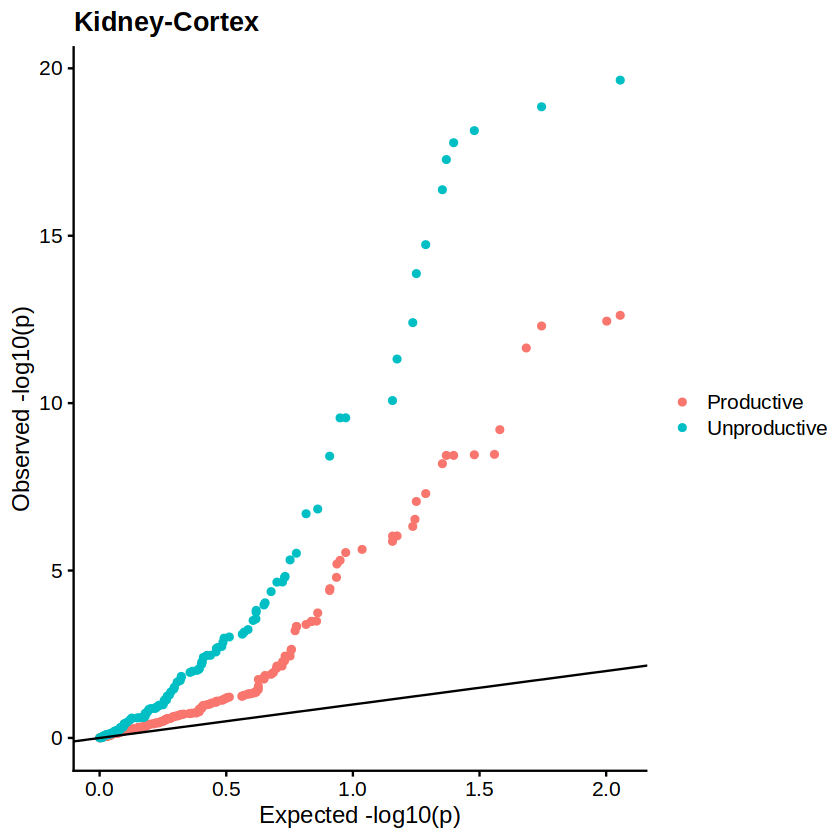

In [303]:
Title <- glue("{tissue}")

qqplot + theme_cowplot() +
  labs(title = Title) +
  theme(legend.title = element_blank())


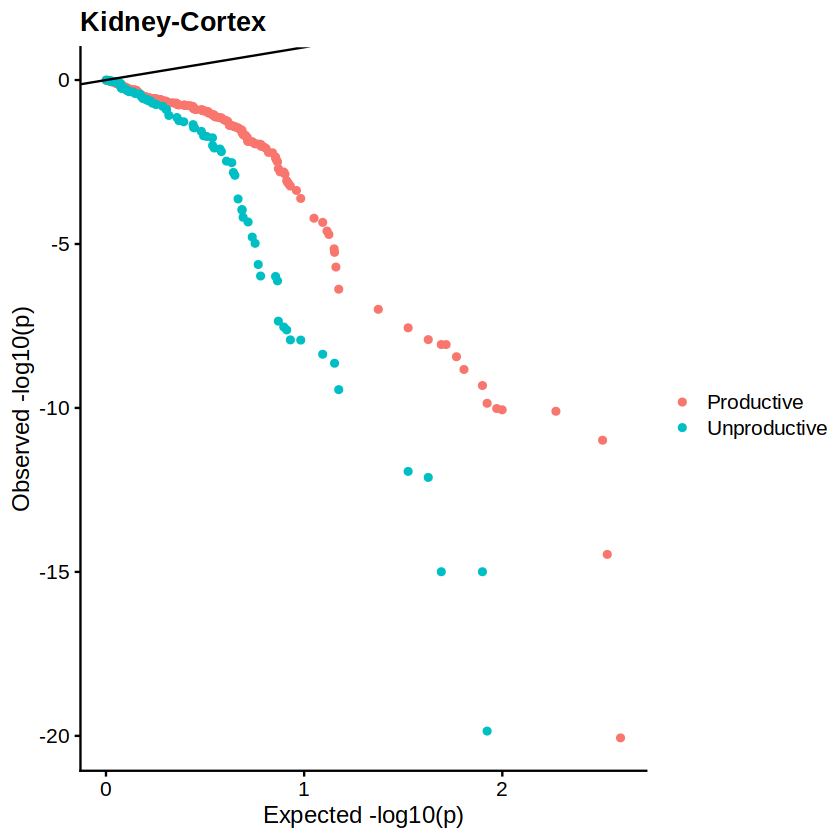

In [304]:
Title <- glue("{tissue}")

qqplotNeg + theme_cowplot() +
  labs(title = Title) +
  theme(legend.title = element_blank())


In [335]:
# first plot sQTL_slope > 0
qqplot <- list(
  Productive = plotDF[ctype == "PR" & slope_sqtl > 0, pval_eqtl],
  Unproductive = plotDF[ctype == "PR,UP" & slope_sqtl > 0, pval_eqtl]
) %>%
  multiqq()

# then plot sQTL_slope < 0
qqplotNeg <- list(
  Productive = plotDF[ctype == "PR" & slope_sqtl < 0, pval_eqtl],
  Unproductive = plotDF[ctype == "PR,UP" & slope_sqtl < 0, pval_eqtl]
) %>%
  multiqq(flipY = TRUE)

Title <- glue("{tissue}")
COLORS <- RColorBrewer::brewer.pal(9, "Blues")[c(4,6)]
names(COLORS) <- c("Productive", "Unproductive")

qqplot <- rbind(qqplot$data, qqplotNeg$data) %>%
  ggplot(aes(x, y, col = group)) + geom_point() +
    geom_abline(intercept = 0, slope = 1) +
    labs(x = "Expected -log10(p)", y = "Observed -log10(p)") +
    scale_color_manual(values = COLORS) + 
    theme_cowplot() +
    theme(legend.title = element_blank())

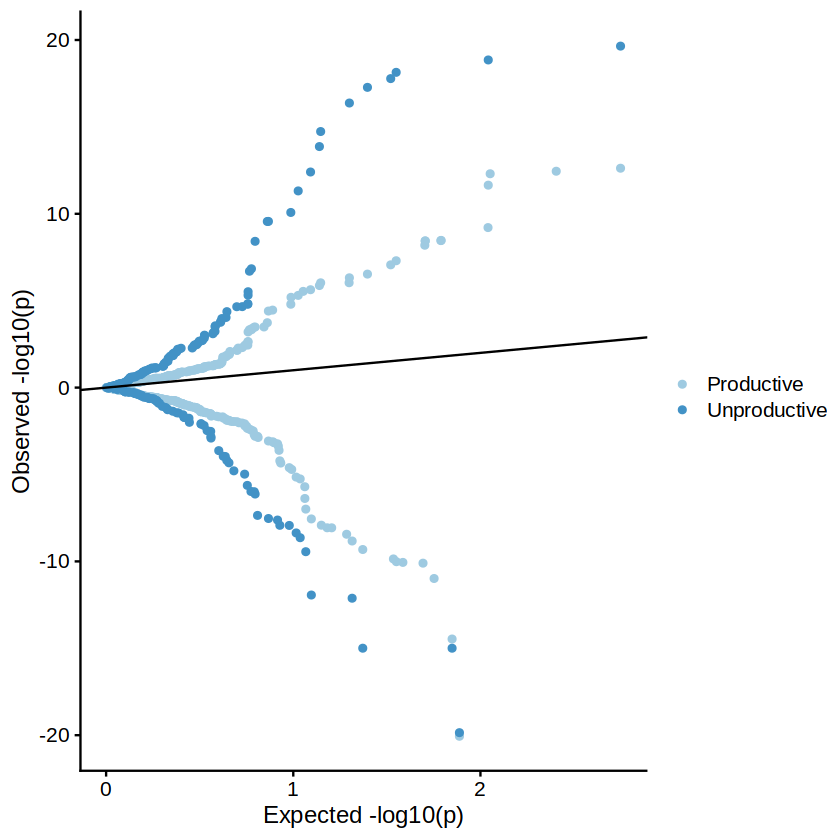

In [336]:
qqplot

In [220]:
dim(plotDF)
plotDF[1:5]
unique(plotDF) %>% dim()


[1] 656   9

gid,intron_id,gene_id,pval_sqtl,pval_eqtl,slope_sqtl,slope_eqtl,ctype,topflag
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<int>
chr1_7961913_G_T_b38,chr1:7961793:7962762:clu_109_+:PR,ENSG00000116288.13,1.07484e-12,0.7470150,-1.085290,-0.02253450,PR,0
chr1_16001621_C_T_b38,chr1:16021513:16021619:clu_215_+:UP,ENSG00000186510.12,2.43948e-07,0.0354621,-0.895701,-0.15084900,"PR,UP",0
chr1_18876402_G_A_b38,chr1:18875503:18877207:clu_1991_-:PR,ENSG00000159423.17,9.57797e-16,0.8887070,1.103610,0.00649479,PR,0
chr1_19351148_G_A_b38,chr1:19326623:19327226:clu_244_+:PR,ENSG00000040487.13,7.92200e-06,0.0137859,-0.723390,0.21842200,PR,1
chr1_22056246_A_G_b38,chr1:22052868:22078428:clu_265_+:PR,ENSG00000070831.17,1.25723e-13,0.9492840,1.279770,-0.00802366,PR,0


[1] 656   9

In [226]:
corr <- plotDF[, .(slope_sqtl, slope_eqtl, ctype = if_else(ctype == "PR", "PR", "UP"))] %>%
  split(by = "ctype") %>%
  map(~ cor.test(x = .x$slope_eqtl, y = .x$slope_sqtl, method = "pearson"))


In [227]:
corr$UP$p.value


[1] 0.03548994

In [228]:
corr


$PR

	Pearson's product-moment correlation

data:  .x$slope_eqtl and .x$slope_sqtl
t = 0.41427, df = 443, p-value = 0.6789
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.07341242  0.11242988
sample estimates:
      cor 
0.0196787 


$UP

	Pearson's product-moment correlation

data:  .x$slope_eqtl and .x$slope_sqtl
t = -2.1164, df = 209, p-value = 0.03549
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.274550534 -0.009980295
sample estimates:
       cor 
-0.1448536 



In [229]:
library(ggpointdensity)


In [230]:
corr <- plotDF[, .(slope_sqtl, slope_eqtl, ctype = if_else(ctype == "PR", "PR", "UP"))] %>%
  split(by = "ctype") %>%
  map(~ cor.test(x = .x$slope_eqtl, y = .x$slope_sqtl, method = "s"))

corr.pvals <- map(corr, ~ .x$p.value) %>% unlist()
corr.estimates <- map(corr, ~ .x$estimate[[1]]) %>% unlist()

if (all(names(corr.pvals) == names(corr.estimates))) {
  corr.df <- data.frame(
    ctype = if_else(names(corr.pvals) == "PR", "Productive", "Unproductive"),
    pval = corr.pvals,
    estimate = corr.estimates
  )
} else {
  stop("names of pvals and estimates do not match")
}


Warning message in cor.test.default(x = .x$slope_eqtl, y = .x$slope_sqtl, method = "s"):
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(x = .x$slope_eqtl, y = .x$slope_sqtl, method = "s"):
“Cannot compute exact p-value with ties”


In [231]:
corr.df <- corr.df %>%
  mutate(xpos = c(0, 0), ypos = c(0, 0))
corr.df


,ctype,pval,estimate,xpos,ypos
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
PR,Productive,0.8618642,-0.00827159,0,0
UP,Unproductive,0.2765704,-0.07524561,0,0


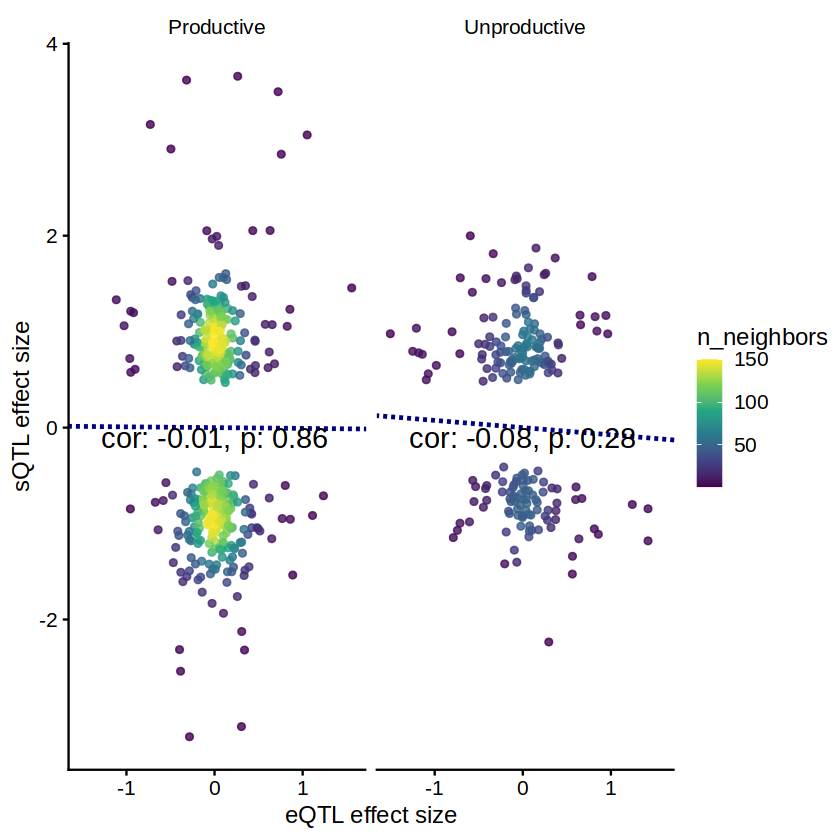

In [277]:
plotDF[, .(slope_sqtl, slope_eqtl, ctype)] %>%
  mutate(ctype = if_else(ctype == "PR", "Productive", "Unproductive")) %>%
  # .[ctype == "Productive"] %>%
  ggplot() +
  geom_pointdensity(aes(slope_eqtl, slope_sqtl), alpha = .8) +
  geom_abline(aes(intercept = 0, slope = estimate), data = corr.df, linetype = "dashed", color = 'navy', linewidth = 1) +
  scale_color_viridis_c() +
  labs(x = "eQTL effect size", y = "sQTL effect size") +
  geom_text(
    aes(
      x = xpos, y = ypos,
      label = glue("cor: {corr}, p: {pvalue}",
        corr = if_else(abs(estimate) > .001, scales::number(estimate, .01), scales::scientific(estimate)),
        pvalue = if_else(pval > .001, scales::number(pval, .01), scales::scientific(pval))
      )
    ),
    data = corr.df, size = 6, hjust = .5, vjust = 1
  ) +
  theme_cowplot() +
  facet_wrap(~ctype) +
  theme(strip.background = element_rect(fill = "white"))


In [117]:
sqtl.gr <- sqtl[, .(phenotype_chr, phenotype_start, phenotype_end, phenotype_strand, phenotype_id)]
sqtl.gr <- makeGRangesFromDataFrame(sqtl.gr,
  keep.extra.columns = TRUE, seqnames.field = "phenotype_chr",
  start.field = "phenotype_start", end.field = "phenotype_end",
  strand.field = "phenotype_strand"
)


In [132]:
sqtl.gr %>% sort()


GRanges object with 2320 ranges and 1 metadata column:
         seqnames            ranges strand |           phenotype_id
            <Rle>         <IRanges>  <Rle> |            <character>
     [1]     chr1     941307-942135      + | chr1:941306:942135:c..
     [2]     chr1   2156093-2169517      + | chr1:2156092:2169517..
     [3]     chr1   6448562-6448640      + | chr1:6448561:6448640..
     [4]     chr1   6449092-6451602      + | chr1:6449091:6451602..
     [5]     chr1   6580050-6580540      + | chr1:6580049:6580540..
     ...      ...               ...    ... .                    ...
  [2316]    chr22 50284666-50285799      - | chr22:50284665:50285..
  [2317]    chr22 50526142-50526245      - | chr22:50526141:50526..
  [2318]    chr22 50571293-50571374      - | chr22:50571292:50571..
  [2319]    chr22 50571534-50572005      - | chr22:50571533:50572..
  [2320]    chr22 50782348-50783500      - | chr22:50782347:50783..
  -------
  seqinfo: 22 sequences from an unspecified genome;

In [121]:
nom.gr <- nomDF[, .(pid, pchr, pstart, pend, pstrand)] %>% unique()
nom.gr <- makeGRangesFromDataFrame(nom.gr,
  keep.extra.columns = TRUE, seqnames.field = "pchr",
  start.field = "pstart", end.field = "pend",
  strand.field = "pstrand"
)


In [124]:
sort(sqtl.gr)


GRanges object with 2320 ranges and 1 metadata column:
         seqnames            ranges strand |           phenotype_id
            <Rle>         <IRanges>  <Rle> |            <character>
     [1]     chr1     941307-942135      + | chr1:941306:942135:c..
     [2]     chr1   2156093-2169517      + | chr1:2156092:2169517..
     [3]     chr1   6448562-6448640      + | chr1:6448561:6448640..
     [4]     chr1   6449092-6451602      + | chr1:6449091:6451602..
     [5]     chr1   6580050-6580540      + | chr1:6580049:6580540..
     ...      ...               ...    ... .                    ...
  [2316]    chr22 50284666-50285799      - | chr22:50284665:50285..
  [2317]    chr22 50526142-50526245      - | chr22:50526141:50526..
  [2318]    chr22 50571293-50571374      - | chr22:50571292:50571..
  [2319]    chr22 50571534-50572005      - | chr22:50571533:50572..
  [2320]    chr22 50782348-50783500      - | chr22:50782347:50783..
  -------
  seqinfo: 22 sequences from an unspecified genome;

In [140]:
x <- GenomicRanges::distanceToNearest(sqtl.gr, nom.gr, select = "arbitrary", ignore.strand = TRUE)


In [141]:
x


Hits object with 2320 hits and 1 metadata column:
         queryHits subjectHits |  distance
         <integer>   <integer> | <integer>
     [1]         1          38 |      2067
     [2]         2          31 |         0
     [3]         3          31 |         0
     [4]         4          22 |         0
     [5]         5          15 |         0
     ...       ...         ... .       ...
  [2316]      2316       11556 |         0
  [2317]      2317       11563 |         0
  [2318]      2318       11558 |         0
  [2319]      2319       11558 |         0
  [2320]      2320       11560 |         0
  -------
  queryLength: 2320 / subjectLength: 11586

In [143]:
x$metada


ERROR: Error in x$metadata: $ operator not defined for this S4 class


In [98]:
sqtl[, .(Nclu = uniqueN(clu)), by = .(ctype)]
sqtl[, .(Nclu = uniqueN(clu)), by = .(qtl_type)]


ctype,Nclu
<chr>,<int>
PR,1313
"PR,UP",1007


qtl_type,Nclu
<chr>,<int>
p-sQTL,1313
u-sQTL,1007


In [95]:
sqtl[ctype == "PR,UP"][, .N, by = itype]


itype,N
<chr>,<int>
PR,1041
UP,870
